In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.model_build import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 64
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


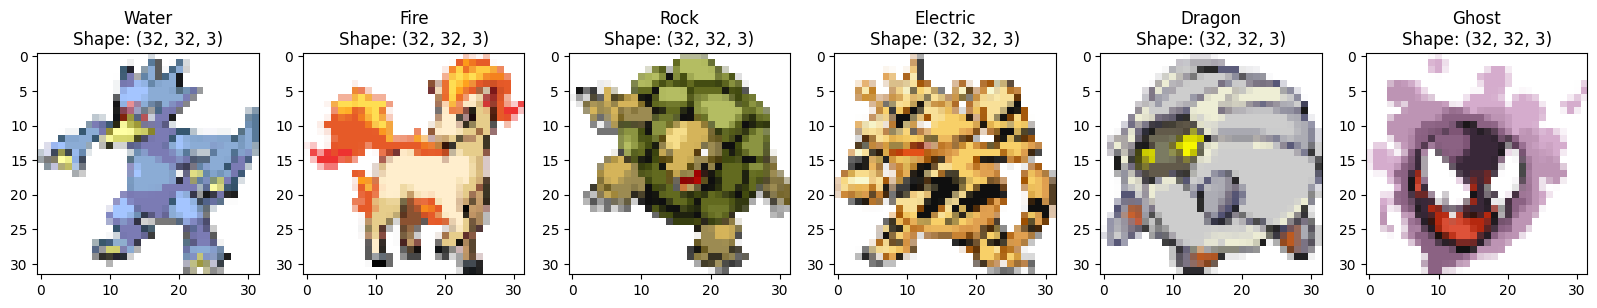

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, num_channels=128, embedding_dim=128)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1715195619.930567   86687 service.cc:145] XLA service 0x72127c001d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715195619.930607   86687 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715195620.518496   86687 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715195622.936526   86836 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6915', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1715195623.996930   86836 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6915', 440 bytes spill stores, 440 bytes spill loads



 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.5731

I0000 00:00:1715195634.184638   86687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.7572
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.3023
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2162
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1781
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1820
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1581
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1752
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1637
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1586
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2581
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1878
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1673
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1023
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1708
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1383


Sampling sprite: 500it [00:30, 16.22it/s]                         


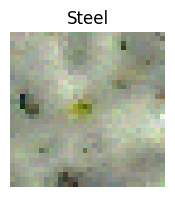

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 554ms/step - loss: 0.1507
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1182
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1323
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1221
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.2073
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0936
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0889
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1580
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1004
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1458
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1085
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1459
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1300
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1232
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:28, 17.55it/s]                         


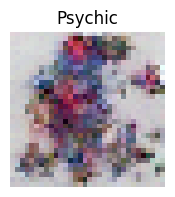

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 518ms/step - loss: 0.1089
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1424
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1569
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1475
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1527
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1294
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1203
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1436
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1478
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1163
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1298
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0840
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0997
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1407
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:27, 17.86it/s]                         


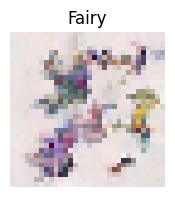

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - loss: 0.0959
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0949
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1174
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1201
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1147
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1034
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1048
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1273
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0869
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0952
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1252
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1748
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1150
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0991
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss

Sampling sprite: 500it [00:28, 17.74it/s]                         


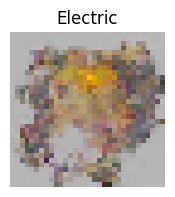

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - loss: 0.0792
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0798
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1405
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1160
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1041
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1074
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1052
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1053
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0923
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1235
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0914
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0834
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1228
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0765
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss

Sampling sprite: 500it [00:26, 18.86it/s]                         


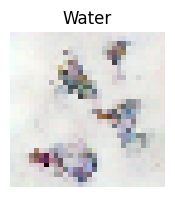

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - loss: 0.1278


In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1093
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1001
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1121
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1374
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1249
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1366
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0881
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0914
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1291
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1156
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0960
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0812
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0890
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1215
Epoch 15/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - lo

Sampling sprite: 500it [00:27, 18.03it/s]                         


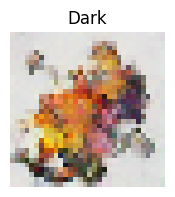

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - loss: 0.1306
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1035
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1163
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1014
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0818
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1406
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1024
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0960
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0779
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1080
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0705
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0824
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1324
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1103
Epoch 34/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:27, 18.19it/s]                         


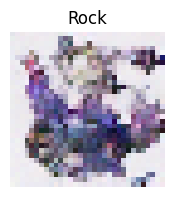

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - loss: 0.1188
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0901
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0752
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0695
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1213
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0698
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0974
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0938
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1024
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1083
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0889
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0830
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0910
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0856
Epoch 54/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:27, 17.99it/s]                         


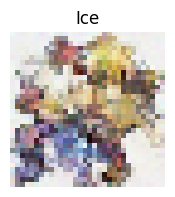

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - loss: 0.0906
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0903
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1170
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1097
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0816
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1154
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0813
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1239
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0934
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0730
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1073
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1194
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1336
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1240
Epoch 74/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:27, 18.12it/s]                         


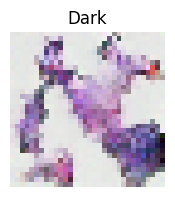

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 503ms/step - loss: 0.1125
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1507
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1348
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1063
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1326
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0781
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0952
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1098
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1028
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0824
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1481
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1044
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0999
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1141
Epoch 94/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss

Sampling sprite: 500it [00:27, 17.87it/s]                         


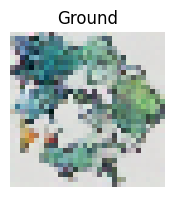

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - loss: 0.1025
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0998
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0860
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0714
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1146
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0937
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0978
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0986
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0791
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1018
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0713
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1074
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0814
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1561
Epoch 114/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 17.94it/s]                         


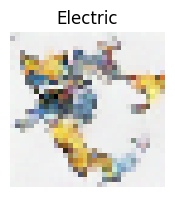

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 508ms/step - loss: 0.0909
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1103
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1062
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0918
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1052
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1320
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0967
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0969
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0789
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1146
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0895
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0858
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0708
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1032
Epoch 134/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.46it/s]                         


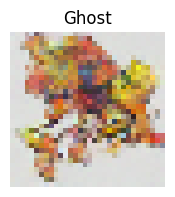

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - loss: 0.1041
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0858
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0992
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1159
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0742
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0926
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0972
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0913
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1193
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0673
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1066
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0985
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0971
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0908
Epoch 154/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.17it/s]                         


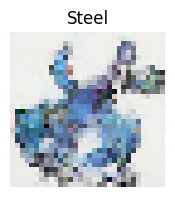

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - loss: 0.0897
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0783
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1228
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1255
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1047
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1275
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1010
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0785
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1212
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1197
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0897
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0883
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0738
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1149
Epoch 174/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.06it/s]                         


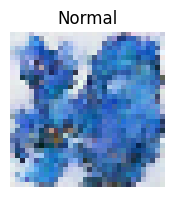

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - loss: 0.1037
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0803
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1173
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0976
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0639
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1031
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0969
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0760
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0833
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1170
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1021
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0848
Epoch 192/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0780
Epoch 193/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0962
Epoch 194/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.18it/s]                         


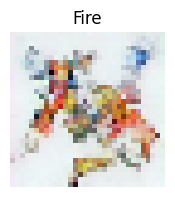

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - loss: 0.1212
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1052
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0692
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0971
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0862
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0866
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1268
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0994
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0813
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1009
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0968
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1160
Epoch 212/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0840
Epoch 213/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0905
Epoch 214/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.17it/s]                         


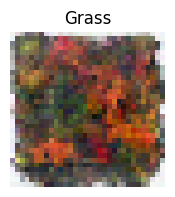

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - loss: 0.1149
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0785
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0752
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1080
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0841
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0895
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0706
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0723
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0874
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0831
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1143
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0775
Epoch 232/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0768
Epoch 233/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0794
Epoch 234/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.31it/s]                         


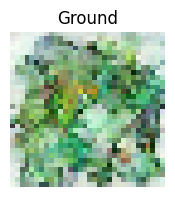

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - loss: 0.1138
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0949
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1039
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0980
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0997
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1046
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0964
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0712
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0895
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0988
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0721
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0701
Epoch 252/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0707
Epoch 253/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0710
Epoch 254/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 17.93it/s]                         


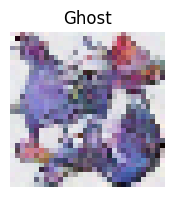

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 508ms/step - loss: 0.1265
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1000
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0738
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0934
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1123
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1145
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0925
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0565
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0892
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0704
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0708
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1335
Epoch 272/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1044
Epoch 273/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0824
Epoch 274/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

Sampling sprite: 500it [00:27, 18.04it/s]                         


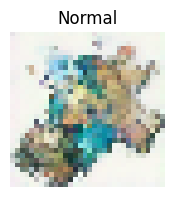

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - loss: 0.1109
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0991
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1125
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0936
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1246
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0915
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0962
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0874
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0919
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0814
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0927
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0862
Epoch 292/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1164
Epoch 293/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1673
Epoch 294/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50

Sampling sprite: 500it [00:28, 17.85it/s]                         


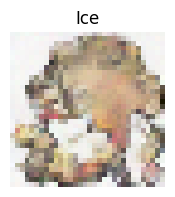

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - loss: 0.0853
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0582
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0723
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1251
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0823
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1017
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0840
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0791
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0794
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0822
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1043
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0836
Epoch 312/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0816
Epoch 313/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0965
Epoch 314/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51

In [8]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

[BACK TO TOP](#top)